<a href="https://colab.research.google.com/github/00150/AI_07_JYP_Project_section_02/blob/main/%F0%9F%8C%8F_%EC%9A%B0%ED%81%AC%EB%9D%BC%EC%9D%B4%EB%82%98_vs_%EB%9F%AC%EC%8B%9C%EC%95%84_%EC%A0%84%EC%9F%81_%EB%B6%84%EC%84%9D_(feat_%EB%94%94%ED%85%8C%EC%9D%BC%ED%95%98%EA%B2%8C_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌏 우크라이나 vs 러시아 전쟁 분석 (feat.디테일하게..)
> 지난번 우리는 우크라이나 러시아 전쟁에 대하여 다중선형회귀까지 진행했습니다.
하지만, 데이터의 이상치 및 편향과 분산등을 전혀 고려하지 않은 채 진행하였습니다.

* 데이터의 이상치 및 정확한 분석에 해가 될 수 있는 부분을 제거하여 최적의 피처를 선택하여 분석히여 봅시다.
* 이번 분석 또한 훈련 및 테스트 데이터를 나눌 때 '2022-08-08'을 기준으로 나눠보겠습니다.

✅ 참고 : 파이썬 내장 함수에서 timestamp에 대하여 float() 등으로 자동으로 변환해주지 않습니다. </br>
- 최적의 피처를 찾는 SelectKBest를 사용하는 경우 시계열 데이터 때문에 'TypeError' 가 발생할 수 있으므로,</br> 
지금 당장은 변환하지 않겠습니다. 

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# 데이터 가져오기.
import pandas as pd
import numpy as np


# 데이터 주소
url_01 = '/content/drive/MyDrive/new_project02/최근_러시아_인명피해_자료.csv'
url_02 = '/content/drive/MyDrive/new_project02/최근_러시아_장비손실_자료.csv'


#데이터 불러오기
df_01 = pd.read_csv(url_01)
df_02 = pd.read_csv(url_02)


# 병합
df = pd.merge(df_01, df_02, on =['date', 'day'])
# 165번 행부터 진행할 것 입니다. 또한 '사망자_수' 나타내는 컬럼은 삭제합니다.

# 컬럼명 변경
df = df.rename(columns = {'date':'날짜','day':'개전일','aircraft':'항공기','helicopter':'헬리콥터','tank' : '탱크',
                    'APC':'장갑차','field artillery': '야포' ,'MRL' :'다중로켓발사기','military auto' : '자동화기기',
                    'fuel tank': '연료탱크', 'drone':'드론' ,'naval ship' : '해군함정', 'anti-aircraft warfare' : '방공포', 'special equipment' : '특수_장비',
                    'mobile SRBM system' : '자동화_탄도_미사일', 'vehicles and fuel tanks' : '탈것_및_연료탱크', 'cruise missiles' : '크루즈_미사일',
                    'greatest losses direction' : '피해가_큰_지역','personnel':'사망자_수', 'personnel*':'불확실한_사망자', 'POW':'전쟁_포로'})


# 컬럼: 날짜 datetime 형태로 변경
df['날짜'] = pd.to_datetime(df['날짜'])


# 누적데이터 -> 일별 데이터로 변경
# 각 컬럼별 차를 계산할 수 없는 데이터 인덱스로 내리기.
df = df.set_index(['날짜', '개전일', '피해가_큰_지역','불확실한_사망자'])

# 각 컬럼별 차이 계산 및 결측값 채우기
df = df.diff().fillna(df).fillna(0).astype(int).reset_index()

# 컬럼 : '피해가_큰_지역' 에 대하여 결측값 채워넣기.
df['피해가_큰_지역'] = df['피해가_큰_지역'].fillna('unknown area')

# 데이터 내의 결측값 확인하기.
# df.isnull().sum() -> 모든 컬럼에 대하여 결측값 : 0


# '2022-08-08'을 기준으로 훈련/테스트 세트를 분리합니다.
# '2022-08-08'은 훈련 데이터에 포함되어야 합니다.
cutoff = pd.to_datetime('2022-08-08')
train = df[df['날짜'] <= cutoff]
test = df[df['날짜'] > cutoff] 

---
### Part 1. 정확도를 올려 데이터를 분석합시다.
> 다양한 모델을 만들었다고 하더라도, 정확도가 좋지 못하면 '쓰레기'입니다 😥

❗ SelectKBest를 사용하여 가장 효과적인 특성 $K$개를 골라봅시다.</br>
❗ 우리의 목표는 target과 가장 관련 있는 features 를 $K$개 고르는 것이 목표입니다.


#### Part 1-2. 범주형 데이터를 숫자형으로 변환하기. (OneHotEncoder)
> 문자형 모델은 내부적으로 처리할 수 없습니다😣
 문자형 데이터를 숫자형으로 변환하는 과정이 필요하며, </br>이 과정이 **'범주형 변수 인코딩'**입니다.

❗ 범주형 데이터는 순서가 없는 '명목형', 순서가 있는 '순서형'으로 나뉩니다.  </br>

❗ 원핫 인코딩 : 범주형 변수의 각 카테고리를 각각 별도의 특성으로 생각하고  그 카테고리가 존재하는 경우에만 1을 넣습니다. </br>

❗ 범주의 종류가 많으면 하이 퀄리티를 가지고 있다고 하며, 이 때 원핫 인코딩은 좋지 않습니다.



#### 진행 방향
>🔅 피처중 '도시'의 이름 및 '불확실한_사망자_수' 을 제외한 범주형 데이터(날짜)는 제거하고, </br> 이 두 컬럼은 원핫인코딩을 진행하여 봅시다.

❗ ```category_encoder ```를 사용하면  범주형 데이터에만 원핫인코딩을 수행할 수 있습니다.




In [10]:
# 원핫인코딩을 사용하기 위한 필요한 라이브러리 설치
!pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# 날짜 컬럼이 제거된 새로운 df 생성 (train & test)
train_df = train.drop('날짜', axis =1)
test_df = test.drop('날짜', axis =1)

# --------------- X_train, y_train, X_test, y_test로 데이터 나누기, 
# target = {column : '사망자_수'}
target = '사망자_수'

# X_train
X_train = train_df.drop(columns=target)

# y_train
y_train = train_df[target]

# X_test
X_test = test_df.drop(columns=target)

# y_test
y_test = test_df[target]


# 데이터 분할 확인하기.
print(f'훈련(독립) : {X_train.shape}, 훈련(종속) :{y_train.shape} \n테스트(독립){X_test.shape}, 테스트(종속){y_test.shape}')


훈련(독립) : (165, 19), 훈련(종속) :(165,) 
테스트(독립)(26, 19), 테스트(종속)(26,)


In [12]:
# 원핫인코더 라이브러리를 가져옵시다.
from category_encoders import OneHotEncoder

#원핫 인코딩을 진행합니다, 먼저 원핫 인코더의 인스턴스 객체를 선언합니다.
encoder = OneHotEncoder(use_cat_names = True)

# 적용
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# 위에서 둘 중 하나의 df를 살펴보면 적용이 되어 있는 것을 확인할 수 있습니다. ex) : X_train.columns or X_test.head()....

In [13]:
# 이후 SelectKBest를 이용하여 가장 효과적인 특성을 살펴보겠습니다.
# 현재 원핫인코딩을 수행하여 나온 피처들의 개수는 총 62개 입니다.


# 먼저 사용할 라이브러리를 선언합니다, 이 때 f_regression은 회귀작업에 대한 레이블/특징사이의 F값입니다...(좀더 찾아봐서 정리해야 합니다..)
from sklearn.feature_selection import f_regression, SelectKBest


#Selector에 대한 인스턴스 객체를 선언 및 정의합니다. (이때 K개의 개수 또한 지정합니다.)
selector = SelectKBest(score_func = f_regression, k=16)

# 학습 데이터에는 fit_transform
X_train_selected = selector.fit_transform(X_train, y_train)

# 테스트 데이터에는 transform
X_test_selected = selector.transform(X_test)

# 모양 확인
print(X_train_selected.shape, X_test_selected.shape)

(165, 16) (26, 16)


#### 이후 선택된 특성을 살펴봅시다.
> SelectKBest로 선택된 컬럼과 그렇지 않은 컬럼의 차이를 살펴봅시다.


In [14]:
#모든 컬럼
all_names = X_train.columns

# 선택된 특성들을 boolean 값으로 돌려준다.
selected_mask = selector.get_support()

# 선택된 특성들을 확인합니다.
selected_names = all_names[selected_mask]

# 선택되지 않은 특성
unselected_names = all_names[~selected_mask]

print('선택된 컬럼들은 다음과 같습니다, :', selected_names)
print('\n')
print('선택되지 않은 컬럼들은 다음과 같습니다. :', unselected_names)

선택된 컬럼들은 다음과 같습니다, : Index(['개전일', '피해가_큰_지역_unknown area', '피해가_큰_지역_Bakhmut', '불확실한_사망자_about',
       '불확실한_사망자_more', '항공기', '헬리콥터', '탱크', '장갑차', '야포', '다중로켓발사기', '자동화기기',
       '연료탱크', '드론', '해군함정', '방공포'],
      dtype='object')


선택되지 않은 컬럼들은 다음과 같습니다. : Index(['피해가_큰_지역_Sievierodonetsk', '피해가_큰_지역_Kurakhove and Izyum',
       '피해가_큰_지역_Zaporizhzhia and Izyum', '피해가_큰_지역_Izyum',
       '피해가_큰_지역_Izyum, Novopavlivsk', '피해가_큰_지역_Popasna',
       '피해가_큰_지역_Lyman and Kurakhove', '피해가_큰_지역_Slobozhanskyi',
       '피해가_큰_지역_Novopavlivsk', '피해가_큰_지역_Avdiivka',
       '피해가_큰_지역_Novopavlivsk, Kurakhove and Sievierodonetsk',
       '피해가_큰_지역_Kurakhove', '피해가_큰_지역_Kurakhove and Avdiivka',
       '피해가_큰_지역_Bakhmut and Zaporizhzhia', '피해가_큰_지역_Lyman and Zaporizhzhia',
       '피해가_큰_지역_Sloviansk, Kryvyi Rih and Zaporizhzhia', '피해가_큰_지역_Lyman',
       '피해가_큰_지역_Avdiivka and Kryvyi Rih', '피해가_큰_지역_Zaporizhzhia',
       '피해가_큰_지역_Kryvyi Rih and Zaporizhzhia',
       '피해가_큰_지역_Kryvyi Rih and Bakhm

#### 🔅 SelectKBest를 무작정 지정하는 것은 위험할 수 있습니다 😥
>임의로 선택한 'k'개수보다 더 최적의 'k'개수가 존재할 수 있습니다.

* K 값들을 증가시키면서 특성들을 뽑아 모델을 만들고, 가장 좋은 부분일 때 뽑아 사용합시다.


In [22]:
# 필요한 라이브러리를 선언합니다.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score


# 훈련 데이터
training = []
testing = []
ks = range(1, len(X_train.columns)+1)


y_pred = ''
y_pred_01 =''

# 1부터 특성 수만큼, 사용한 모델을 만들어서 MAE 값을 비교하여 봅시다.
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')

  # SelectKBest  인스턴스 객체 선언
  selector = SelectKBest(score_func=f_regression, k=k)

  # 훈련데이터 fit_transform
  X_train_selected = selector.fit_transform(X_train, y_train)

  # 테스트데이터 transform
  X_test_selected = selector.transform(X_test)


  # 원 데이터의 전체 컬럼 확인하기.
  all_names = X_train.columns
  
  
  # 선택된 컬럼을 부울린의 값으로 알려줍니다. : get_support()
  selected_mask = selector.get_support()
  selected_names = all_names[selected_mask]
  print('선택된 컬럼 이름 : selected_names', selected_names)

  # 선형회귀를 사용하기 위한 객체 인스턴스
  model = LinearRegression()

  #적용  
  model.fit(X_train_selected, y_train)

  # 예측값.
  #기준모델
  y_pred = model.predict(X_train_selected)
  
  # 평균절대오차 (예측값과 실제값을 이용)
  mae = mean_absolute_error(y_train, y_pred)
  training.append(mae)

  #------------------------------------------
  #실제 데이터를 통한 예측
  #기준모델이 아닌 것.
  y_pred_01 = model.predict(X_test_selected)
  
  # 평균절대값에러
  mae = mean_absolute_error(y_test, y_pred_01)

  # r2_score
  r2 = r2_score(y_test, y_pred_01)
  testing.append(mae)

  # 테스트 데이터에 관한 mae 값 출력
  print(f'Test MAE : {mae:,.0f}')
  
  # 테스트 데이터에 관한 r2스코어 값 출력
  print(f'Test R2:{r2}\n')

1 features
선택된 컬럼 이름 : selected_names Index(['장갑차'], dtype='object')
Test MAE : 76
Test R2:-0.1144810355835475

2 features
선택된 컬럼 이름 : selected_names Index(['장갑차', '연료탱크'], dtype='object')
Test MAE : 77
Test R2:-0.14632990395914258

3 features
선택된 컬럼 이름 : selected_names Index(['탱크', '장갑차', '연료탱크'], dtype='object')
Test MAE : 77
Test R2:-0.14495202314387678

4 features
선택된 컬럼 이름 : selected_names Index(['탱크', '장갑차', '야포', '연료탱크'], dtype='object')
Test MAE : 90
Test R2:-0.5825899501556644

5 features
선택된 컬럼 이름 : selected_names Index(['헬리콥터', '탱크', '장갑차', '야포', '연료탱크'], dtype='object')
Test MAE : 95
Test R2:-0.7133216353189467

6 features
선택된 컬럼 이름 : selected_names Index(['헬리콥터', '탱크', '장갑차', '야포', '자동화기기', '연료탱크'], dtype='object')
Test MAE : 95
Test R2:-0.7147569333009576

7 features
선택된 컬럼 이름 : selected_names Index(['항공기', '헬리콥터', '탱크', '장갑차', '야포', '자동화기기', '연료탱크'], dtype='object')
Test MAE : 97
Test R2:-0.7100974260840152

8 features
선택된 컬럼 이름 : selected_names Index(['개전일', '항공기', '헬리콥

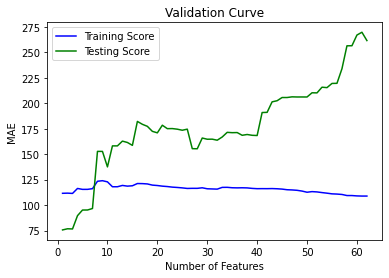

In [23]:
plt.plot(ks, training, label = 'Training Score', color='b')
plt.plot(ks, testing, label = 'Testing Score', color='g')
plt.ylabel('MAE')
plt.xlabel('Number of Features')
plt.title('Validation Curve')
plt.legend()  
plt.show()

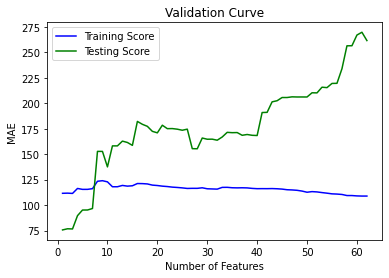

In [19]:
#-------------------------------------------------
# 나온 값을 기반으로 그래프를 그려봅시다.
# 필요한 라이브러리 import

import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(ks, training, label = 'Training Score', color='b')
plt.plot(ks, testing, label = 'Testing Score', color='g')
plt.ylabel('MAE')
plt.xlabel('Number of Features')
plt.title('Validation Curve')
plt.legend()  
plt.show()


* 훈련데이터의 경우 피처의 개수가 늘어남 or 줄어듬에 관계없이 MAE 값이 거의 일정합니다.

* 반면에, 테스트 데이터의 경우 피처의 개수가 늘어나면 전체적으로 MAE값이 불규칙하게 높아집니다.

❗ MAE는 scale에 의존적입니다, 에러의 크기 또한 크기를 그대로 반영하여, 실제값보다 낮은 값으로 예측되는 것인지, 실제보다 높은 값으로 예측되는 것인지 알 수 없습니다.

❗ 훈련데이터의 값에 비하여 테스트 데이터의 MAE 값이 불규칙하게 상승합니다
  'k'의 개수가 11~12개 정도가 적당해보입니다.

#### 하지만 문제점이 생깁니다❗❗
##😫 R2_score 값이 음수 입니다..!!
#### 결과만 말하자면....우리가 사용하고 있는 데이터는 '쓰레기' 이고, 회귀분석을 이용하는데에 적합하지 않은 데이터라는 것입니다.


##Part 2. 쓰레기 데이터를 이용한 모델을 고쳐야합니다.
> 정확한 예측을 진행하기 위해 먼저 기존 데이터에 대한 이상치 조정을 해보는 것도 하나의 방법일 것입니다....


